## Exploratory Data Analysis of datasets

In [22]:
# import packages
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

### SQuAD2.0 dataset

In [40]:
# Load and merge SQuAD2.0 train and dev sets, then use only the merged set for all analysis

def load_squad_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        squad_dict = json.load(f)
    data = []
    for article in squad_dict['data']:
        title = article.get('title', None)
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                qid = qa['id']
                is_impossible = qa.get('is_impossible', False)
                if is_impossible:
                    answers = []
                else:
                    answers = [ans['text'] for ans in qa['answers']]
                data.append({
                    'id': qid,
                    'title': title,
                    'question': question,
                    'context': context,
                    'answers': answers,
                    'is_impossible': is_impossible
                })
    return pd.DataFrame(data)

# File paths
squad_train_file = 'data/SQuAD2/SQuAD2_train-v2.0.json'
squad_dev_file = 'data/SQuAD2/SQuAD2_dev-v2.0.json'

# Load datasets
train_df_squad = load_squad_dataset(squad_train_file)
dev_df_squad = load_squad_dataset(squad_dev_file)

# Merge train and dev sets
squad_df = pd.concat([train_df_squad, dev_df_squad], ignore_index=True)
squad_df.to_csv('data/SQuAD2/SQuAD2_merged.csv', index=False)

# Display shape and head for verification
print("Merged SQuAD shape:", squad_df.shape)
print(squad_df.head())

Merged SQuAD shape: (142192, 6)
                         id    title  \
0  56be85543aeaaa14008c9063  Beyoncé   
1  56be85543aeaaa14008c9065  Beyoncé   
2  56be85543aeaaa14008c9066  Beyoncé   
3  56bf6b0f3aeaaa14008c9601  Beyoncé   
4  56bf6b0f3aeaaa14008c9602  Beyoncé   

                                            question  \
0           When did Beyonce start becoming popular?   
1  What areas did Beyonce compete in when she was...   
2  When did Beyonce leave Destiny's Child and bec...   
3      In what city and state did Beyonce  grow up?    
4         In which decade did Beyonce become famous?   

                                             context                answers  \
0  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...    [in the late 1990s]   
1  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...  [singing and dancing]   
2  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...                 [2003]   
3  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...       [Houston, Texas

Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv


C:\Users\Chris\AppData\Local\Temp\ipykernel_17212\903504938.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Answerable", "Unanswerable"],


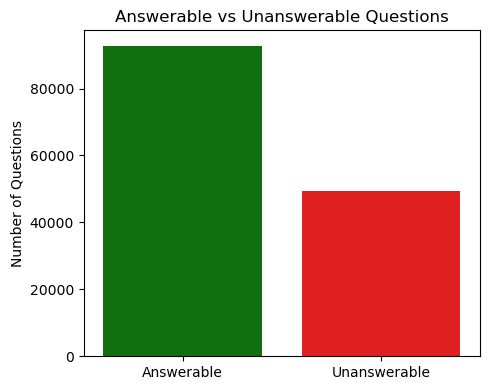

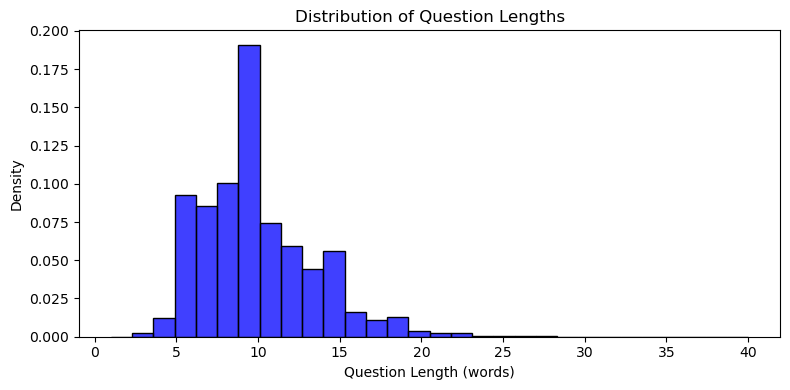

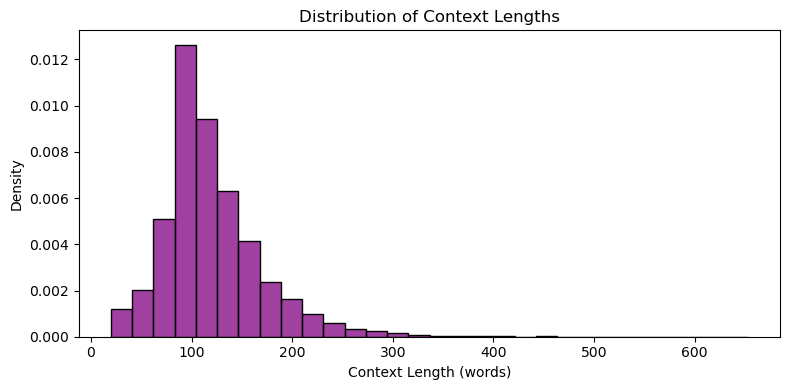

  Dataset  Total Questions  Answerable Questions  Unanswerable Questions  \
0  Merged           142192                 92749                   49443   

   Avg Answers per Answerable Question  Avg Question Length (words)  \
0                             1.154977                     9.904327   

   Avg Context Length (words)  
0                  120.306768  


In [51]:
# Create output folders if they don't exist
os.makedirs("figures/SQuAD", exist_ok=True)
os.makedirs("tables/SQuAD", exist_ok=True)

# Function to compute dataset stats
def compute_stats(df, name):
    total_questions = len(df)
    unanswerable_count = df['is_impossible'].sum()
    answerable_count = total_questions - unanswerable_count
    avg_answers_per_question = df[df['is_impossible'] == False]['answers'].apply(len).mean()
    avg_question_length = df['question'].apply(lambda x: len(x.split())).mean()
    avg_context_length = df['context'].apply(lambda x: len(x.split())).mean()
    return {
        'Dataset': name,
        'Total Questions': total_questions,
        'Answerable Questions': answerable_count,
        'Unanswerable Questions': unanswerable_count,
        'Avg Answers per Answerable Question': avg_answers_per_question,
        'Avg Question Length (words)': avg_question_length,
        'Avg Context Length (words)': avg_context_length
    }

# Compute stats for merged SQuAD
stats_squad = compute_stats(squad_df, "Merged")
stats_df_squad = pd.DataFrame([stats_squad])

# Save stats table
stats_df_squad.to_csv("tables/SQuAD/squad2_summary_stats.csv", index=False)
print("Saved dataset summary to tables/SQuAD/squad2_summary_stats.csv")

# ----------- Visualization 1: Answerable vs Unanswerable ------------
plt.figure(figsize=(5, 4))
sns.barplot(x=["Answerable", "Unanswerable"],
            y=[stats_squad['Answerable Questions'], stats_squad['Unanswerable Questions']],
            palette=["green", "red"])
plt.ylabel("Number of Questions")
plt.title("Answerable vs Unanswerable Questions")
plt.tight_layout()
plt.savefig("figures/SQuAD/answerable_vs_unanswerable.png")
plt.show()

# ----------- Visualization 2: Question Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(squad_df['question'].apply(lambda x: len(x.split())), kde=False, bins=30, color='blue', stat="density")
plt.xlabel("Question Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Question Lengths")
plt.tight_layout()
plt.savefig("figures/SQuAD/question_length_distribution.png")
plt.show()

# ----------- Visualization 3: Context Length Distribution ------------
plt.figure(figsize=(8, 4))
sns.histplot(squad_df['context'].apply(lambda x: len(x.split())), kde=False, bins=30, color='purple', stat="density")
plt.xlabel("Context Length (words)")
plt.ylabel("Density")
plt.title("Distribution of Context Lengths")
plt.tight_layout()
plt.savefig("figures/SQuAD/context_length_distribution.png")
plt.show()

print(stats_df_squad)

C:\Users\Chris\AppData\Local\Temp\ipykernel_17212\4013852126.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis')


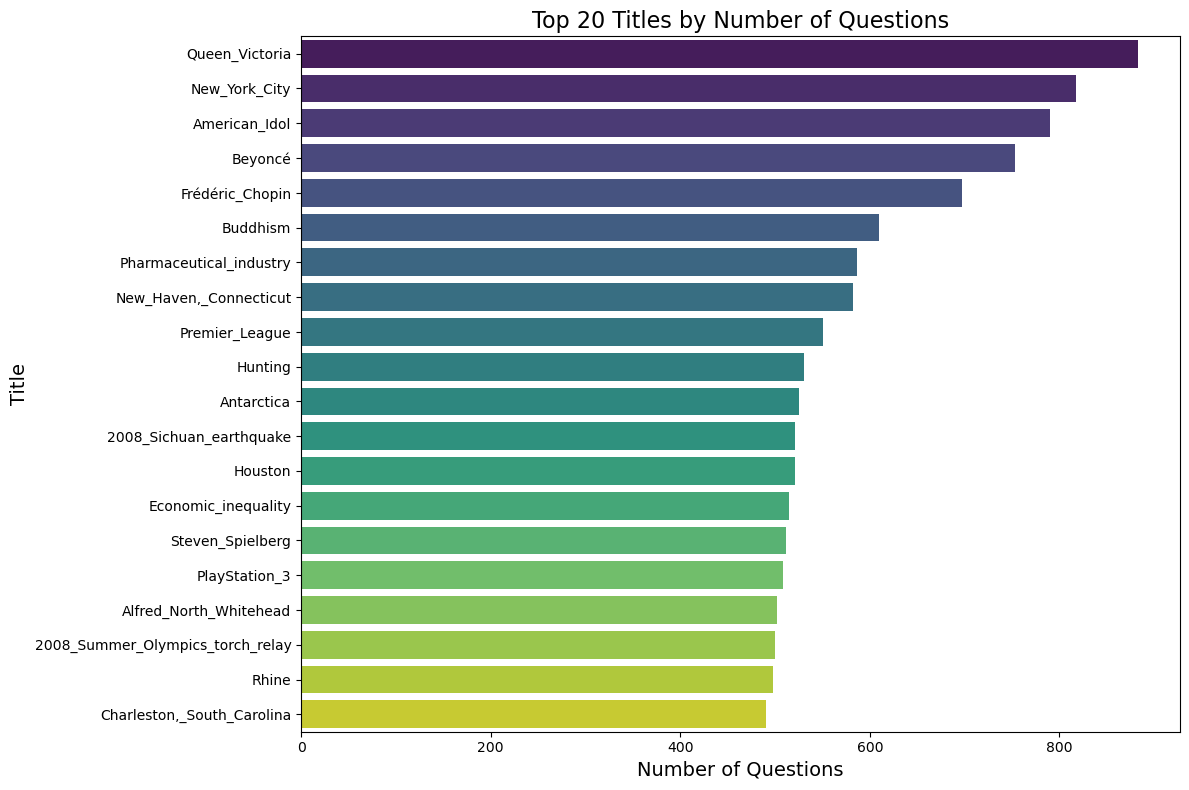

Title distribution statistics:
   Total unique titles  Average questions per title  \
0                  477                   298.096436   

   Median questions per title  Max questions per title  \
0                       282.0                      883   

   Min questions per title  Std Dev of questions per title  
0                       36                      107.984316  


In [50]:
# Create a visualization of counts per title in merged SQuAD dataset

# Count questions per title
title_counts = squad_df['title'].value_counts()

# Visualize the top 20 titles by question count
plt.figure(figsize=(12, 8))
top_titles = title_counts[:20]
sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis')
plt.title('Top 20 Titles by Number of Questions', fontsize=16)
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('Title', fontsize=14)
plt.tight_layout()
plt.savefig("figures/SQuAD/title_distribution.png")
plt.show()

# Calculate statistics about title distribution
title_stats = {
    'Total unique titles': len(title_counts),
    'Average questions per title': title_counts.mean(),
    'Median questions per title': title_counts.median(),
    'Max questions per title': title_counts.max(),
    'Min questions per title': title_counts.min(),
    'Std Dev of questions per title': title_counts.std()
}

# Display statistics as a DataFrame
title_stats_df = pd.DataFrame([title_stats])
print("Title distribution statistics:")
print(title_stats_df)

# Save statistics to CSV
title_stats_df.to_csv("tables/SQuAD/title_distribution_stats.csv", index=False)

In [43]:
# --- Create example instance table from merged SQuAD ---
example_squad = squad_df[squad_df['answers'].apply(lambda x: len(x) > 0)].iloc[0]
example_table_squad = pd.DataFrame({
    "Title": [example_squad['title']],
    "Context": [example_squad['context']],
    "Question": [example_squad['question']],
    "Answer": [example_squad['answers'][0]]
})
example_table_squad.to_csv("tables/SQuAD/squad2_example_instance.csv", index=False)
example_table_squad

,Title,Context,Question,Answer
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s


In [44]:
# Concatenate text of all rows in each column for merged SQuAD
all_context_text_squad = ' '.join(squad_df["context"].tolist())
all_question_text_squad = ' '.join(squad_df["question"].tolist())
all_answer_text_squad = ' '.join(squad_df["answers"].apply(lambda x: ' '.join(x)).tolist())

# Calculate word frequency using Counter
context_word_freq_squad = Counter(all_context_text_squad.split())
question_word_freq_squad = Counter(all_question_text_squad.split())
answer_word_freq_squad = Counter(all_answer_text_squad.split())

# Get the top 15 most frequent words for each column
top_context_words_squad = dict(context_word_freq_squad.most_common(15))
top_question_words_squad = dict(question_word_freq_squad.most_common(15))
top_answer_words_squad = dict(answer_word_freq_squad.most_common(15))

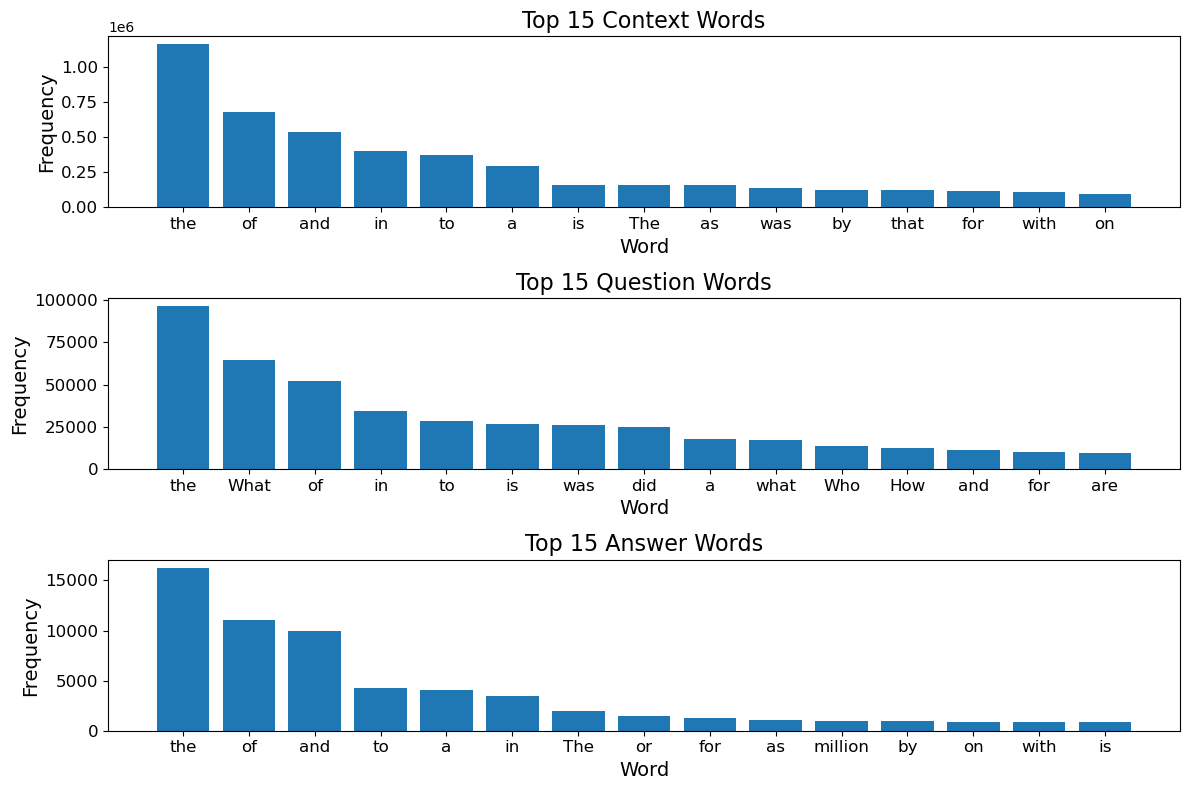

In [ ]:
# Plot bar plots for merged SQuAD
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].bar(top_context_words_squad.keys(), top_context_words_squad.values())
axs[0].set_title("Top 15 Context Words", fontsize=16)
axs[0].set_xlabel("Word", fontsize=14)
axs[0].set_ylabel("Frequency", fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)

axs[1].bar(top_question_words_squad.keys(), top_question_words_squad.values())
axs[1].set_title("Top 15 Question Words", fontsize=16)
axs[1].set_xlabel("Word", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)

axs[2].bar(top_answer_words_squad.keys(), top_answer_words_squad.values())
axs[2].set_title("Top 15 Answer Words", fontsize=16)
axs[2].set_xlabel("Word", fontsize=14)
axs[2].set_ylabel("Frequency", fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig("figures/SQuAD/train_word_frequency.png")
plt.show()

In [46]:
# Function to generate word cloud from word frequency and save the plot (merged SQuAD)
def generate_wordcloud_and_save(word_freq, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"figures/SQuAD/{filename}")
    plt.close()
    plt.show()

# Generate word clouds and save plots
generate_wordcloud_and_save(context_word_freq_squad, "context_wordcloud.png")
generate_wordcloud_and_save(question_word_freq_squad, "question_wordcloud.png")

### TriviaQA

In [54]:
# --- TriviaQA: Use only merged DataFrame for all analysis ---

def load_triviaqa_dataset(file_path):
    import json
    import pandas as pd
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    data = []
    for item in data_dict.get('Data', []):
        question = item.get('Question', None)
        question_id = item.get('QuestionId', None)
        question_source = item.get('QuestionSource', None)
        answers = []
        answer_dict = item.get('Answer', {})
        if isinstance(answer_dict, dict):
            if 'NormalizedValue' in answer_dict and answer_dict['NormalizedValue']:
                answers.append(answer_dict['NormalizedValue'])
            if 'Aliases' in answer_dict and answer_dict['Aliases']:
                answers.extend(answer_dict['Aliases'])
            if 'NormalizedAliases' in answer_dict and answer_dict['NormalizedAliases']:
                answers.extend(answer_dict['NormalizedAliases'])
        answers = list(set(filter(None, answers)))
        data.append({
            'question': question,
            'question_id': question_id,
            'question_source': question_source,
            'answers': answers
        })
    df = pd.DataFrame(data)
    df['answers'] = df['answers'].apply(lambda x: list(set(filter(None, x))))
    return df

# File paths
trivia_train_file = 'data/triviaqa-unfiltered/unfiltered-web-train.json'
trivia_dev_file = 'data/triviaqa-unfiltered/unfiltered-web-dev.json'

# Load and merge datasets
train_df_trivia = load_triviaqa_dataset(trivia_train_file)
dev_df_trivia = load_triviaqa_dataset(trivia_dev_file)
trivia_df = pd.concat([train_df_trivia, dev_df_trivia], ignore_index=True)
trivia_df.to_csv('data/triviaqa-unfiltered/trivia_all.csv', index=False)

# Display shape and head for verification
print("Train TriviaQA shape:", train_df_trivia.shape)
print("Dev TriviaQA shape:", dev_df_trivia.shape)
print("Merged TriviaQA shape:", trivia_df.shape)
print(trivia_df.head())

Train TriviaQA shape: (87622, 4)
Dev TriviaQA shape: (11313, 4)
Merged TriviaQA shape: (98935, 4)
                                            question question_id  \
0  Who was President when the first Peanuts carto...        tc_0   
1  Which American-born Sinclair won the Nobel Pri...        tc_1   
2         Where in England was Dame Judi Dench born?        tc_3   
3  William Christensen of Madison, New Jersey, ha...        tc_4   
4  In which decade did Billboard magazine first p...        tc_5   

                 question_source  \
0  http://www.triviacountry.com/   
1  http://www.triviacountry.com/   
2  http://www.triviacountry.com/   
3  http://www.triviacountry.com/   
4  http://www.triviacountry.com/   

                                             answers  
0  [Mary Jane Truman, president truman, Mr. Citiz...  
1  [Sinclair Lewis, Harry Sinclair Lewis, Grace H...  
2  [yoisk, York, England, Eoferwic, weather in yo...  
3                             [beer cans, Beer Cans]  
4

Saved dataset summary to tables/TriviaQA/triviaqa_summary_stats.csv


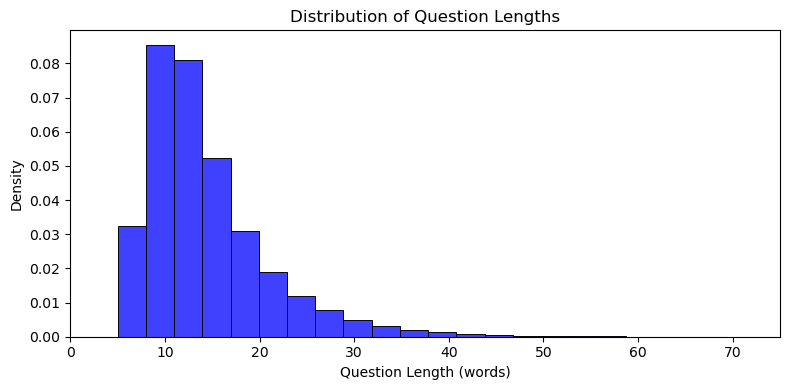

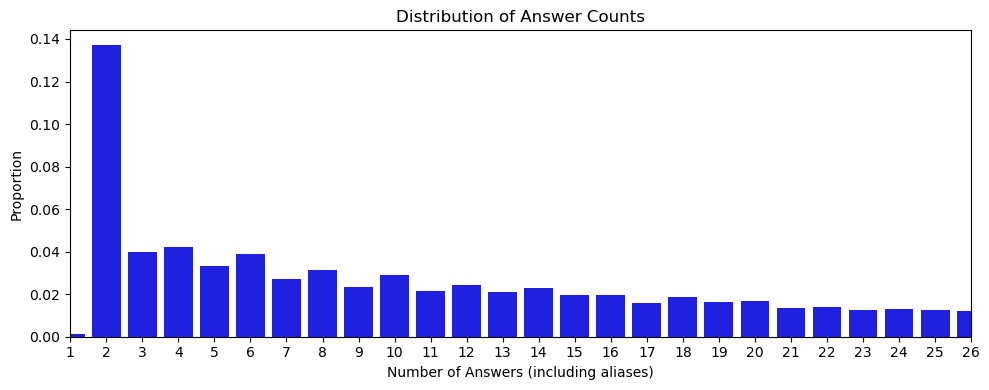

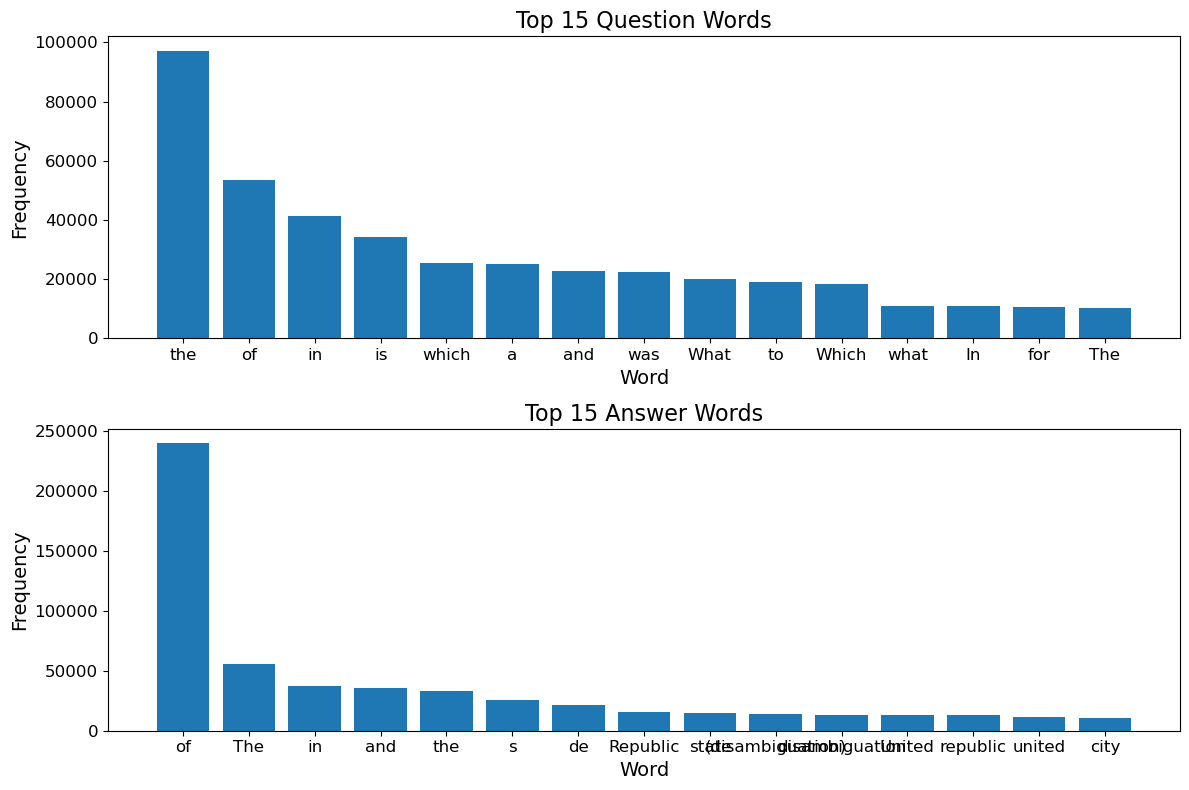


Example Instance:
                                            Question  \
0  Who was President when the first Peanuts carto...   

                                             Answers  
0  Mary Jane Truman, president truman, Mr. Citize...  


In [ ]:
color_val = "#0000FF"  # Standard blue

# Create output folders
os.makedirs("figures/TriviaQA", exist_ok=True)
os.makedirs("tables/TriviaQA", exist_ok=True)

# Compute dataset statistics for merged TriviaQA
def compute_triviaqa_stats(df, name):
    total_questions = len(df)
    avg_answers_per_question = df['answers'].apply(len).mean()
    avg_question_length = df['question'].apply(lambda x: len(x.split())).mean()
    return {
        'Dataset': name,
        'Total Questions': total_questions,
        'Avg Answers per Question': avg_answers_per_question,
        'Avg Question Length (words)': avg_question_length,
    }

stats_trivia = compute_triviaqa_stats(trivia_df, "Merged")
stats_df_trivia = pd.DataFrame([stats_trivia])
stats_df_trivia.to_csv("tables/TriviaQA/triviaqa_summary_stats.csv", index=False)
print("Saved dataset summary to tables/TriviaQA/triviaqa_summary_stats.csv")

# Visualization 2: Question Length Distribution (Merged)
plt.figure(figsize=(8, 4))
sns.histplot(trivia_df['question'].apply(lambda x: len(x.split())), kde=False, bins=60, color=color_val, stat="density")
plt.xlabel("Question Length (words)")
plt.ylabel("Density")
plt.xlim(0, 75)
plt.title("Distribution of Question Lengths")
plt.tight_layout()
plt.savefig("figures/TriviaQA/question_length_distribution.png")
plt.show()

# Visualization 3: Number of Answers Distribution (Merged)
plt.figure(figsize=(10, 4))
answers_count_trivia = trivia_df['answers'].apply(len).value_counts().sort_index()
counts_data_trivia = pd.DataFrame({
    'Count': answers_count_trivia.index,
    'Proportion': answers_count_trivia.values / len(trivia_df)
})
sns.barplot(data=counts_data_trivia, x='Count', y='Proportion', color=color_val)
plt.xlabel("Number of Answers (including aliases)")
plt.ylabel("Proportion")
plt.xlim(0, 25)
plt.title("Distribution of Answer Counts")
plt.tight_layout()
plt.savefig("figures/TriviaQA/answer_count_distribution.png")
plt.show()

# Word frequency analysis (Merged)
all_question_text_trivia = ' '.join(trivia_df["question"].tolist())
all_answer_text_trivia = ' '.join(trivia_df["answers"].apply(lambda x: ' '.join(x)).tolist())
question_word_freq_trivia = Counter(all_question_text_trivia.split())
answer_word_freq_trivia = Counter(all_answer_text_trivia.split())
top_question_words_trivia = dict(question_word_freq_trivia.most_common(15))
top_answer_words_trivia = dict(answer_word_freq_trivia.most_common(15))

# Plot word frequencies (Merged)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.bar(top_question_words_trivia.keys(), top_question_words_trivia.values())
ax1.set_title("Top 15 Question Words", fontsize=16)
ax1.set_xlabel("Word", fontsize=14)
ax1.set_ylabel("Frequency", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.bar(top_answer_words_trivia.keys(), top_answer_words_trivia.values())
ax2.set_title("Top 15 Answer Words", fontsize=16)
ax2.set_xlabel("Word", fontsize=14)
ax2.set_ylabel("Frequency", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig("figures/TriviaQA/word_frequency.png")
plt.show()

# Generate and save word clouds
def generate_wordcloud_and_save_trivia(word_freq, filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"figures/TriviaQA/{filename}")
    plt.close()
    plt.show()

generate_wordcloud_and_save_trivia(question_word_freq_trivia, "question_wordcloud.png")
generate_wordcloud_and_save_trivia(answer_word_freq_trivia, "answer_wordcloud.png")

# Create example instance table (Merged)
example_trivia = trivia_df.iloc[0]
example_table_trivia = pd.DataFrame({
    "Question": [example_trivia['question']],
    "Answers": [', '.join(example_trivia['answers'])]
})
example_table_trivia.to_csv("tables/TriviaQA/triviaqa_example_instance.csv", index=False)
print("\nExample Instance:")
print(example_table_trivia)